In [1]:
#imports
import torch
import torch.nn.functional as F
import torch.nn as nn
from gym import spaces
from torch.optim import Optimizer
import numpy as np
# from dqn.model import DQN
# from dqn.replay_buffer import ReplayBuffer
import numpy as np
from collections import deque
import gym
from gym import spaces
import cv2
import random
from nle import nethack
import minihack
from PIL import Image
import os
from IPython.display import clear_output



In [2]:
print(torch.cuda.is_available())

False


In [3]:
# Set device to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### helper stuff

In [4]:
def format_state(state):
    """Formats state into form that the NN can accept"""
    glyphs = state["glyphs"]
    # Normalize
    glyphs = glyphs/glyphs.max()
    glyphs = glyphs.reshape((1,1,21,79))
    return torch.from_numpy(glyphs).squeeze(0)

In [5]:
def display_screen(state):
    """Displays the state as the screen in image form using the 'pixel' observation key"""
    screen = Image.fromarray(np.uint8(state['pixel']))
    display(screen)

In [6]:
class ReplayBuffer:
    """
    Simple storage for transitions from an environment.
    """

    def __init__(self, size):
        """
        Initialise a buffer of a given size for storing transitions
        :param size: the maximum number of transitions that can be stored
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, state, action, reward, next_state, done):
        """
        Add a transition to the buffer. Old transitions will be overwritten if the buffer is full.
        :param state: the agent's initial state
        :param action: the action taken by the agent
        :param reward: the reward the agent received
        :param next_state: the subsequent state
        :param done: whether the episode terminated
        """
        data = (state, action, reward, next_state, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, indices):
        states, actions, rewards, next_states, dones = [], [], [], [], []
        for i in indices:
            data = self._storage[i]
            state, action, reward, next_state, done = data
            states.append(np.array(state, copy=False))
            actions.append(action)
            rewards.append(reward)
            next_states.append(np.array(next_state, copy=False))
            dones.append(done)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)

    def sample(self, batch_size):
        """
        Randomly sample a batch of transitions from the buffer.
        :param batch_size: the number of transitions to sample
        :return: a mini-batch of sampled transitions
        """
        indices = np.random.randint(0, len(self._storage) - 1, size=batch_size)
        return self._encode_sample(indices)

## Model

In [7]:

class DQN(nn.Module):
    """
    A basic implementation of a Deep Q-Network.
    """

    def __init__(self, action_space: spaces.Discrete):
        """
        Initialise the DQN
        :param action_space: the action space of the environment
        """
        super().__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=20,kernel_size=(5, 5))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50,kernel_size=(5, 5))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=1600, out_features=500)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=500, out_features=action_space.n)


    def forward(self, x):
        """
        Returns the values of a forward pass of the network
        :param x: The input to feed into the network 
        """
        # define first conv layer with max pooling
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # define second conv layer with max pooling
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # Define fully connected layers
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

## Agent

In [8]:
# Define class that brings all the DQN compenents together so that a model can be trained
class DQNAgent():
    def __init__(self, observation_space, action_space, **kwargs):
        global device
        self.action_space = action_space
        self.replay_buffer = kwargs.get("replay_buffer", None)
        self.use_double_dqn = kwargs.get("use_double_dqn", None)
        self.gamma = kwargs.get("gamma", 0.99)
        self.lr = kwargs.get("lr", None)
        self.betas = kwargs.get("betas", (0.9, 0.999))
        self.batch_size = kwargs.get("batch_size", None)
        # Create the online and target network
        self.online_network = DQN(action_space).to(device)
        self.target_network = DQN(action_space).to(device)
        self.optimiser = torch.optim.Adam(self.online_network.parameters(), lr=self.lr, betas=self.betas)
   

    def optimise_td_loss(self):
        """
        Optimise the TD-error over a single minibatch of transitions
        :return: the loss
        """
        states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        with torch.no_grad():
            if self.use_double_dqn:
                _, max_next_action = self.online_network(next_states).max(1)
                max_next_q_values = self.target_network(next_states).gather(1, max_next_action.unsqueeze(1)).squeeze()
            else:
                next_q_values = self.online_network(next_states)
                max_next_q_values, _ = next_q_values.max(1)
            target_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        input_q_values = self.target_network(states)
        input_q_values = input_q_values.gather(1, actions.unsqueeze(1)).squeeze()

        loss = F.smooth_l1_loss(input_q_values, target_q_values)

        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        del states
        del next_states
        return loss.item()

    def update_target_network(self):
        """
        Update the target Q-network by copying the weights from the current Q-network
        """
        self.target_network.load_state_dict(self.online_network.state_dict())

    def act(self, observation):
        """Select action base on network inference"""
        if not torch.cuda.is_available():
            observation = observation.type(torch.FloatTensor) 
        else:
            observation = observation.type(torch.cuda.FloatTensor) 
        state = torch.unsqueeze(observation, 0).to(device)
        result = self.online_network.forward(state)
        action = torch.argmax(result).item()
        return action

## Train

In [9]:
def dqn(env, seed, learning_rate, max_episodes, max_episode_length, gamma, verbose=True):

    hyper_params = {
        'replay-buffer-size': 100000, # replay buffer size
        'gamma': 0.99,  # discount factor
        'learning-rate': learning_rate, # learning rate for Adam optimizer
        'num-steps': int(2e5),  # total number of steps to run the environment for
        'batch-size': 256,  # number of transitions to optimize at the same time
        'learning-starts': 50000,  # set learning to start after 1000 steps of exploration
        'learning-freq': 5,  # number of iterations between every optimization step
        'use-double-dqn': True, # use double deep Q-learning
        'target-update-freq': 50000, # number of iterations between every target network update
        'eps-start': 1.0,  # e-greedy start threshold 
        'eps-end': 0.08,  # e-greedy end threshold 
        'eps-fraction': 0.08,  # fraction of num-steps
        'print-freq': 10,

    }

    np.random.seed(42)
    env.seed(42)
    
    # Create DQN agent
    replay_buffer = ReplayBuffer(hyper_params['replay-buffer-size'])
    agent = DQNAgent(
        env.observation_space, 
        env.action_space,
        train=True,
        replay_buffer=replay_buffer,
        use_double_dqn=hyper_params['use-double-dqn'],
        lr=hyper_params['learning-rate'],
        batch_size=hyper_params['batch-size'],
        gamma=hyper_params['gamma'],
    )
    
    # define variables to track agent metrics
    total_reward = 0
    scores = []
    mean_rewards = []

    eps_timesteps = hyper_params["eps-fraction"] * float(hyper_params["num-steps"])
    episode_rewards = [0.0]

    # Reset gym env before training
    state = format_state(env.reset())
    eps_timesteps = hyper_params['eps-fraction'] * float(hyper_params['num-steps'])
    # Train for set number of steps
    for t in range(hyper_params['num-steps']):
        # determine exploration probability
        fract = min(1.0, float(t) / eps_timesteps)
        eps_threshold = hyper_params["eps-start"] + fract * (hyper_params["eps-end"] - hyper_params["eps-start"])
        sample = random.random()
        # Decide to explore and choose random action or use model to act
        if sample < eps_threshold:
            action = np.random.choice(agent.action_space.n)
        else:
            action = agent.act(state)
        # Take step in environment
        (next_state, reward, done, _) = env.step(action)
        next_state = format_state(next_state)
        replay_buffer.add(state, action, reward, next_state, float(done))
        total_reward += reward
        state = next_state
        if done:
            scores.append(total_reward)
            print(f"episode reward: {total_reward}")
            np.random.seed(seed)
            env.seed(seed)
            state = format_state(env.reset())
            total_reward = 0

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["learning-freq"] == 0
        ):
            agent.optimise_td_loss()

        if (
            t > hyper_params["learning-starts"]
            and t % hyper_params["target-update-freq"] == 0
        ):
            agent.update_target_network()

        num_episodes = len(scores)
        if done and hyper_params['print-freq'] is not None and len(scores) % hyper_params['print-freq'] == 0:
            clear_output(wait=True)
            mean_100ep_reward = round(np.mean(scores[-101:-1]), 1)
            mean_rewards.append(mean_100ep_reward)
            print('********************************************************')
            print('steps: {}'.format(t))
            print('episodes: {}'.format(num_episodes))
            print('mean 100 episode reward: {}'.format(mean_100ep_reward))
            print('% time spent exploring: {}'.format(eps_threshold))
            print('********************************************************')
            #env.render()
  
        if num_episodes >=max_episodes:
            return scores

    return scores

In [10]:
def run_dqn(env,number_episodes,max_episode_length,iterations):
    """Trains DQN model for a number of episodes on a given environment"""
    seeds = np.random.randint(1000, size=iterations)
    scores_arr = [] 
    
    for i in range(iterations):
        # Train the DQN Model 
        scores = dqn(env=env, 
                        seed=42, 
                        learning_rate=1e-3,
                        max_episodes=number_episodes, 
                        max_episode_length=max_episode_length, 
                        gamma=0.99 ,
                        verbose=True)
        # Store rewards for this iteration 
        scores_arr.append(scores)
        
    return scores_arr

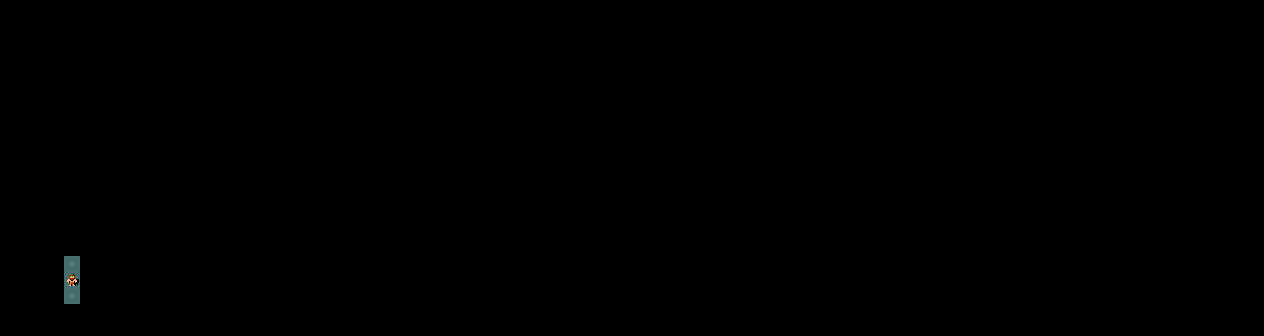

In [11]:
MOVE_ACTIONS = tuple(nethack.CompassDirection)
NAVIGATE_ACTIONS = MOVE_ACTIONS + (
    nethack.Command.PICKUP,
    nethack.Command.APPLY,
    nethack.Command.FIRE,
    nethack.Command.RUSH,
    nethack.Command.ZAP,
    nethack.Command.PUTON,
    nethack.Command.READ,
    nethack.Command.WEAR,
    nethack.Command.QUAFF,
    nethack.Command.PRAY,
    nethack.Command.OPEN
    )
env = gym.make("MiniHack-Quest-Hard-v0", observation_keys=["glyphs","pixel","message"], actions=NAVIGATE_ACTIONS)
# Reset the environment and display the screen of the starting state 
display_screen(env.reset())
# env.render()

In [12]:
guest_hard = run_dqn(env,number_episodes=2000,max_episode_length=200,iterations=1)

********************************************************
steps: 83478
episodes: 150
mean 100 episode reward: -7.7
% time spent exploring: 0.07999999999999996
********************************************************
episode reward: -9.929999999999833
episode reward: -9.919999999999833


In [30]:
guest_hard

[[-0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -0.4100000000000002,
  -0.4200000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -0.7200000000000004,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4000000000000002,
  -0.4200000000000002,
  -0.4100000000000002,
  -0.4000000000000002,
  -0.4200000000000002,
  -0.4300000000000002,
  -0.4100000000000002,
  -0.4000000000000002,
  -0.4100000000000002,
  -1.7100000000000013,
  -0.4100000000000002,
  -0.4100000000000002,
  -0.4100000000000002,
  -0.4100000000000002,
  -0.420000